# Задача с Kaggle о предсказании оттока пользователей компании. Необходимо решить задачу бинарной классификации

In [1]:
import pandas as pd
import numpy as np
from  matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

## Загрузка и исследование данных

In [3]:
data = pd.read_csv('/content/train.csv') # '/kaggle/input/advanced-dls-spring-2021/train.csv'

In [ ]:
data.head(2)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0


In [ ]:
data.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

Видим, что столбец TotalSpent имеет тип object, хотя мы ожидаем там float. Дело в том, что чиловые значения здесь записаны строками. Однако напрямую преобразовать в число их нельзя, т.к. содержатся пустые строки. Поэтому заменим ' ' на 'Nan', затем преобразуем столбце в число.

In [4]:
header = data.columns[:-1]
num_cols = header[[0, 1, 2, 4]].to_list()
cat_cols = header[3 :].delete(1).to_list()
target_col = data.columns[-1]

In [5]:
if sum((data[num_cols[2]] == ' ' ) | (data[num_cols[2]] == '' )) != 0:
  data[num_cols[2]].replace([' ', ''], ['Nan', 'Nan'], inplace=True)
data[num_cols[2]] = data[num_cols[2]].astype(float)

In [6]:
nan_count = data.isna().sum()
print(f'Nan is not defined') if max(nan_count) == 0 else  print(nan_count[nan_count != 0 ])

TotalSpent    9
dtype: int64


Заменим Nan на среднее месячных трат

In [7]:
data['TotalSpent'].fillna(data['MonthlySpending'].mean(), inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

### Гистограммы числовых признаков

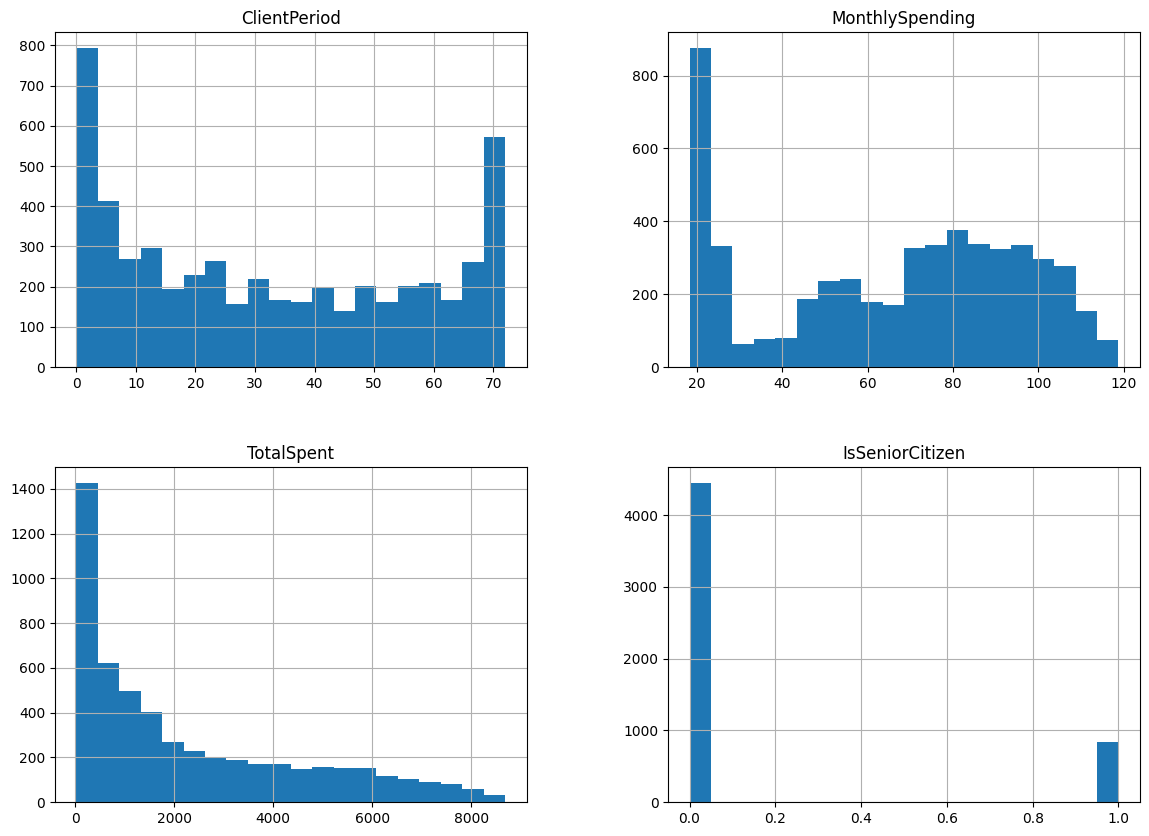

In [9]:
from matplotlib import pyplot as plt
data[num_cols].hist(figsize = (14, 10),  bins=20)
None

Попробуем посмотреть логарифмированный график 'TotalSpent', может, он будет более сбалансирован. А также построим график отношения 'TotalSpent'/'ClientPeriod'.

In [10]:
added_cols = pd.DataFrame({'TotalSpen_div_ClPeriod': data['TotalSpent']/(data['ClientPeriod']+1),
                           'log_TotalSpent': np.log1p(data['TotalSpent'])})

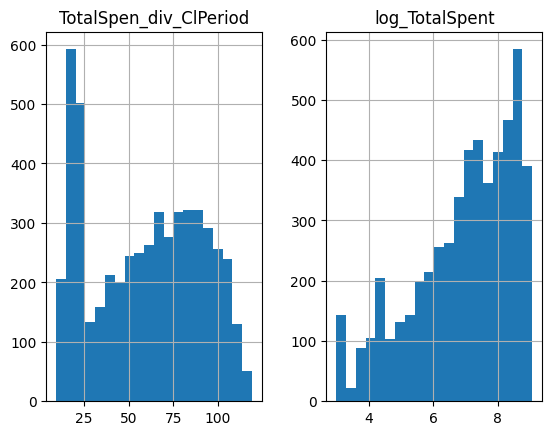

In [11]:
added_cols.hist(bins=20)
None

Из графиокв видно, что разница между максимумами и остальными значениями сократилась. Добавим эти два столбца в матрицу признаков X_added и затем сравним предсказания с исходной матрицей признаков X. 
Матрицу признаков X и вектор целевого признакак Y создадим ниже

In [12]:
X = data[num_cols]
X_added = pd.concat([X, added_cols], axis=1)
Y = data[target_col]

### Таблица корреляции признаков

Построим  карту корреляции между числовыми признаками и целевым признаком. 

In [13]:
X_for_corr = pd.concat([X_added, data[target_col]], axis=1)
X_for_corr.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-13-7c29c95ebb2b>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  X_for_corr.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,TotalSpen_div_ClPeriod,log_TotalSpent,Churn
ClientPeriod,1.00,0.25,0.83,0.01,0.41,0.83,-0.35
MonthlySpending,0.25,1.00,0.65,0.22,0.96,0.58,0.18
TotalSpent,0.83,0.65,1.00,0.09,0.76,0.83,-0.20
IsSeniorCitizen,0.01,0.22,0.09,1.00,0.20,0.10,0.16
TotalSpen_div_ClPeriod,0.41,0.96,0.76,0.20,1.00,0.74,0.07
log_TotalSpent,0.83,0.58,0.83,0.10,0.74,1.00,-0.24
Churn,-0.35,0.18,-0.20,0.16,0.07,-0.24,1.00


Из карты корреляции видим, что существенных (близких к 1) взаимосвязей между признаками и целью нет, однако 0,35 тоже неплохо. Обратим внимание, на добавленные признаки. Log_TotalSpent имеет корреляцию с целевым признаком 0,24, а  TotalSpe_div_ClPeriod - значительно меньше 0,07. Посокльку TotalSpe_div_ClPeriod корреляция с целью близка к нулю уберем его из рассмотрения.

In [14]:
X_added.drop(['TotalSpen_div_ClPeriod'], axis=1, inplace=True)
num_cols_added = X_added.columns.to_list()

### Гистограмы категориальных признаков

Посмотрим на категориальные признаки.
Отобразим те из них, которые соответствуют оттоку клиентов, то есть Churn=1

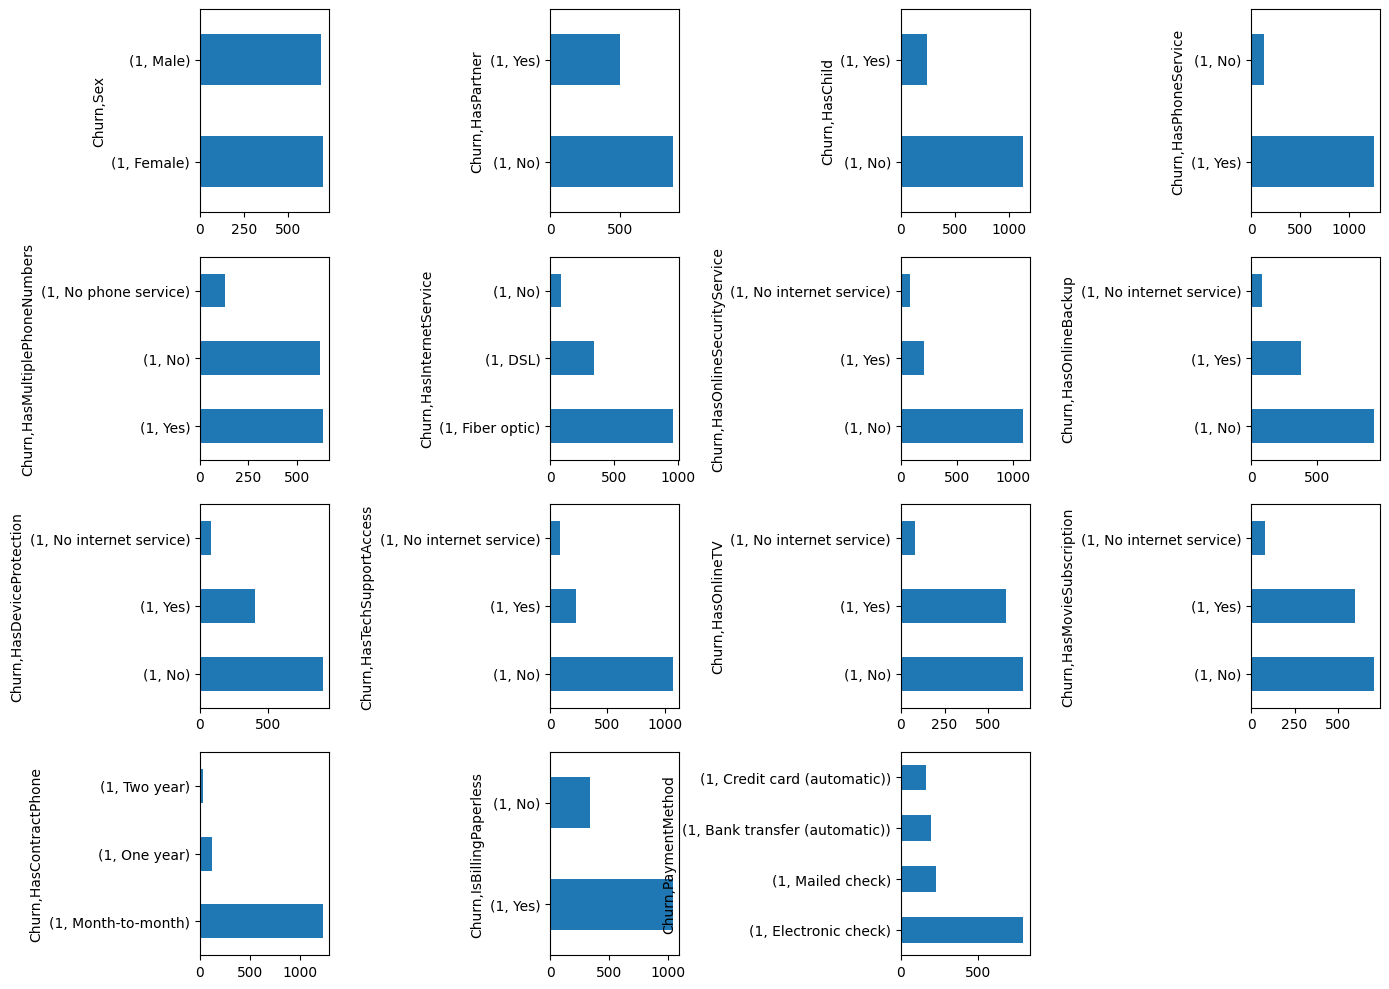

In [15]:
data_churn = data[data[target_col]==1] 

n = 4
n_subplots = int(np.ceil(len(cat_cols)/n))
for i in range(len(cat_cols)):
  plt.subplot(n_subplots, n, i+1, in_layout=True)
  plt.tight_layout()
  data_churn[[cat_cols[i], target_col]].groupby(target_col).value_counts().plot.barh(figsize=(14, 10), ylabel=cat_cols[i])


Из графиков видно, что некоторые категориальные признаки выразительны например, HasDeviceProtection, HasOnlineSecurityService, HasOnlineBackup. Это обнадеживает))

Преобразуем категориальные признаки в бинарные с помощью one-hot-encoding и добавим их в матрицы признаков X и X_added

In [16]:
df_cat_encod = pd.get_dummies(data[cat_cols], columns = cat_cols)
X_cat_encod = X.copy()
X_cat_encod = pd.concat([X_cat_encod, df_cat_encod], axis = 1)
X_added = pd.concat([X_added, df_cat_encod], axis = 1)
# X содержит только num_cols. Добавим столбцы cat_cols как категориальные 
X = pd.concat([X, data[cat_cols]], axis=1)

name_cols = X_cat_encod.columns.to_list()
for name in num_cols:
  name_cols.remove(name)
name_cols
cat_encod_cols = name_cols

Посмотрим распределение целевого признака:

<Axes: >

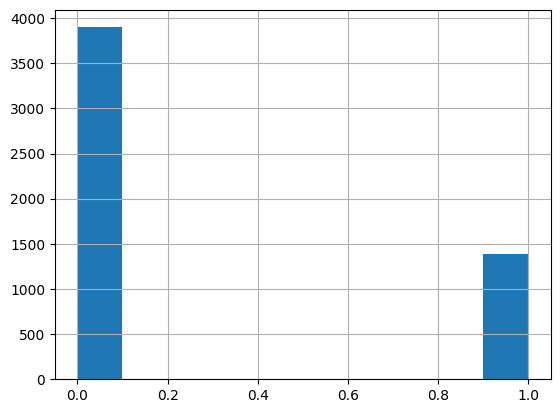

In [17]:
Y.hist()

In [18]:
part_1 = data[target_col].value_counts()[1] / data[target_col].value_counts()[0]

part_1 = 0.355 - это количсество представителей 1 класса в выборке. Говорит о том, что выборка немного не сбалансированна, поэтому не используем метрику accuracy, будем пользоваться метрикой roc_auc

## Логистическая регрессия

Создадим функцию для предсказания целевого признака(оттока клиентов) логистическим регрессором. Внутри функции будем проводить стандартизацию числовых признаков. Коэффициент регуляризации C является входным параметром функции (чтоб можно было подобрать лучший).
Возвращает функция кортеж из оценок roc_auc для тренировочной части выборки и для тестовой

In [19]:
def roc_auc_LogReg(x, y, c):
  x_train, x_test, y_train, y_test = train_test_split(x , y, test_size=0.3, random_state = 42)
  index_train = x_train.index
  index_test = x_test.index
  
  ssc = StandardScaler()
  x_num_train_sc = ssc.fit_transform(x_train[num_cols])
  x_num_test_sc = ssc.transform(x_test[num_cols])
  x_num_train_sc = pd.DataFrame(x_num_train_sc, columns=num_cols, index = index_train)
  x_num_test_sc = pd.DataFrame(x_num_test_sc, columns=num_cols, index = index_test)

  x_train_sc = pd.concat([x_num_train_sc, x_train[cat_encod_cols]], axis = 1)
  x_test_sc = pd.concat([x_num_test_sc, x_test[cat_encod_cols]], axis = 1)

  lr = LogisticRegression(penalty='l2', 
                          C=c,
                          class_weight='balanced',
                          solver='liblinear')
  
  lr.fit(x_train_sc, y_train)
  y_proba = lr.predict_proba(x_test_sc)
  y_proba_train = lr.predict_proba(x_train_sc)

  return roc_auc_score(y_train, y_proba_train[:,1]), roc_auc_score(y_test, y_proba[:,1])

In [20]:
C = [0.001, 0.01, 0.1, 1, 5, 10, 20, 100]
roc_auc = np.empty((len(C),2))
for i, c in enumerate(C):
  roc_auc[i] = roc_auc_LogReg(X_cat_encod, Y, c)

best_C = C[np.argmax(roc_auc[:,1])]
best_score = round(max(roc_auc[:,1]), 4)
print(f'roc_auc= {best_score} with C= {best_C}')

roc_auc= 0.8316 with C= 1


In [21]:
C = [0.001, 0.01, 0.1, 1, 5, 10, 20, 100]
roc_auc = np.empty((len(C),2))
for i, c in enumerate(C):
  roc_auc[i] = roc_auc_LogReg(X_added, Y, c)

best_C = C[np.argmax(roc_auc[:,1])]
best_score = round(max(roc_auc[:,1]), 4)
print(f'roc_auc= {best_score} with C= {best_C}')

roc_auc= 0.8316 with C= 1


Как видно из двух предыдущих ячеек, точность предсказания одинаковая на обеих матрицах признаков и состоавляет 0.8316 при C=1.

Построим пайплайн для поиска параметров логистической регрессии с помощью GrigSearchCV. 

In [22]:
log_total_spent = np.log1p(data['TotalSpent'])
log_total_spent.rename('Log_TotalSpent', inplace=True)
X = pd.concat([X, log_total_spent], axis = 1)
X.head(2)

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Log_TotalSpent
0,55,19.50,1026.35,0,Male,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,6.934738
1,72,25.85,1872.20,0,Male,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),7.535403


## Pipeline для стандартизации числовых признаков,OneHotEncoding категориальных признаков. Поиск параметров регрессора по сетке с кросс-валидацией.
## Обучение модели

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols), 
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='if_binary'), cat_cols)],
     verbose_feature_names_out = False)

lrmodel = Pipeline(steps=[
    ('enc', preproc), 
    ('alg', LogisticRegression(max_iter=200))
])

params = {
    'alg__C': [0.001, 0.01, 0.1, 1, 5, 10, 20], 
    'alg__penalty':['l2', 'none'],  
    'alg__solver':['liblinear', 'lbfgs'], 
    'alg__class_weight':['balanced']
}

lr = GridSearchCV(lrmodel, params, cv=5, verbose=0, n_jobs=-1, scoring='roc_auc')

lr.fit(X, Y)
print(f'best_params_: {lr.best_params_}')
print(f'best_score_: {lr.best_score_}')

best_params_: {'alg__C': 0.001, 'alg__class_weight': 'balanced', 'alg__penalty': 'none', 'alg__solver': 'lbfgs'}
best_score_: 0.8448000310555672


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fi

Поиск по сетке определил параметры best_params_: {'alg__C': 0.001, 'alg__class_weight': 'balanced', 'alg__penalty': 'none', 'alg__solver': 'lbfgs'}
Лучшая оценка модели: best_score_: 0.8448000310555672

## Загрузка тестовых данных

Загрузим тестовые данные и сделаем прогноз

In [24]:
data_test = pd.read_csv('/content/test.csv') # /kaggle/input/advanced-dls-spring-2021/test.csv

In [25]:
data_test.head(2)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.1,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.5,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check


In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [ ]:
if sum(data_test['TotalSpent'] == ' ') > 0:
  data_test['TotalSpent'].replace(' ', 'Nan', inplace=True)
data_test['TotalSpent'] = data_test['TotalSpent'].astype('float')
data_test['TotalSpent'].fillna(data_test['MonthlySpending'].mean(), inplace=True)

In [ ]:
log_total_spent = np.log1p(data_test['TotalSpent'])
log_total_spent.rename('Log_TotalSpent', inplace=True)
data_test = pd.concat([data_test[num_cols], data_test[cat_cols], log_total_spent], axis = 1)
data_test.head(2)

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Sex,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Log_TotalSpent
0,42,56.1,2386.85,0,Male,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic),7.778149
1,29,98.5,3004.15,1,Male,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,8.008083


## Предсказание на тестовых данных

Сделаем прогноз с помощью пайплайна

In [ ]:
test_proba = lr.predict_proba(data_test)

In [ ]:
test_proba

array([[0.89049808, 0.10950192],
       [0.11560021, 0.88439979],
       [0.15147673, 0.84852327],
       ...,
       [0.12018591, 0.87981409],
       [0.16584406, 0.83415594],
       [0.97090453, 0.02909547]])

In [ ]:
#submit = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/submission.csv', index_col='Id')

submit['Churn'] = test_proba[:,1]

submit.to_csv('submission.csv')

## Градиентный бустинг

Выполним предсказание с помощью градиетного бустинга библиотеки catboost

In [ ]:
!pip install catboost
import catboost # документация: https://catboost.ai/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
boosting_model = catboost.CatBoostClassifier(n_estimators = 100,
                                             cat_features = cat_cols)
boosting_model.fit(X_train,Y_train)

Learning rate set to 0.157457
0:	learn: 0.6046239	total: 10.2ms	remaining: 1.01s
1:	learn: 0.5531296	total: 18.1ms	remaining: 886ms
2:	learn: 0.5166271	total: 26.7ms	remaining: 862ms
3:	learn: 0.4885372	total: 34.6ms	remaining: 831ms
4:	learn: 0.4710422	total: 42.5ms	remaining: 808ms
5:	learn: 0.4490565	total: 54.6ms	remaining: 855ms
6:	learn: 0.4358622	total: 62.2ms	remaining: 826ms
7:	learn: 0.4260809	total: 70.2ms	remaining: 808ms
8:	learn: 0.4206964	total: 78ms	remaining: 788ms
9:	learn: 0.4163906	total: 85.5ms	remaining: 769ms
10:	learn: 0.4105174	total: 93.3ms	remaining: 755ms
11:	learn: 0.4059948	total: 101ms	remaining: 743ms
12:	learn: 0.4038875	total: 110ms	remaining: 734ms
13:	learn: 0.4001830	total: 118ms	remaining: 724ms
14:	learn: 0.3991499	total: 123ms	remaining: 699ms
15:	learn: 0.3984009	total: 128ms	remaining: 674ms
16:	learn: 0.3966531	total: 137ms	remaining: 667ms
17:	learn: 0.3943129	total: 144ms	remaining: 657ms
18:	learn: 0.3929102	total: 152ms	remaining: 648ms
19

In [ ]:
Y_pred_train = boosting_model.predict_proba(X_train)
Y_pred_test = boosting_model.predict_proba(X_test)

scor_train = roc_auc_score(Y_train, Y_pred_train[:,1])
scor_test = roc_auc_score(Y_test, Y_pred_test[:,1])
print(scor_train, scor_test)

0.8958686392158658 0.8189179080355741


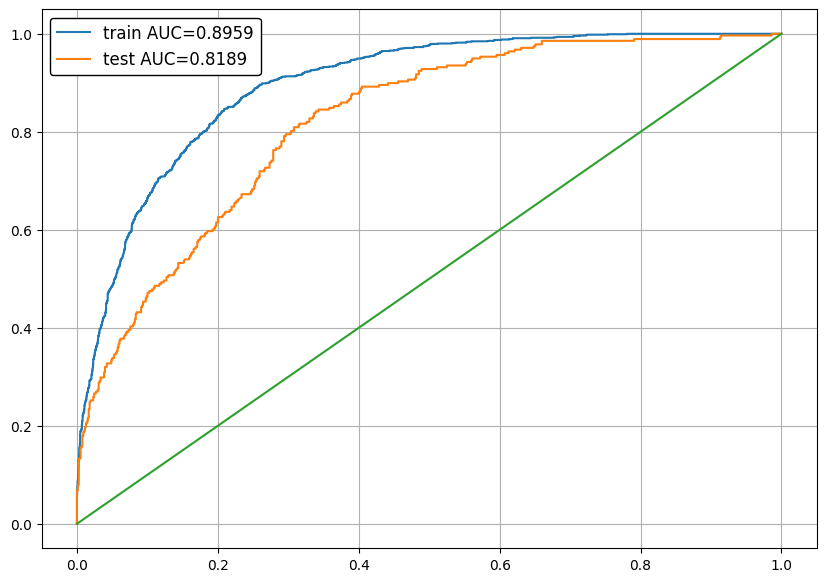

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(Y_train, Y_pred_train[:,1])[:2], label='train AUC={:.4f}'.format(scor_train))
plt.plot(*roc_curve(Y_test, Y_pred_test[:,1])[:2], label='test AUC={:.4f}'.format(scor_test))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.grid()
plt.show()


Точность модели 0,8255 на тестовой подвыборке.
Определим лучшее качество модели в зависимости от количества деревьев [50, 100, 150, 200, 250].

In [ ]:
n_estimators = [50, 100, 150, 200, 250]
def boosting(x_train, x_test, y_train, y_test, n_estimators):
  boosting_model = catboost.CatBoostClassifier(cat_features= cat_cols,
                                             eval_metric = 'AUC',
                                             n_estimators = n_estimators)
  boosting_model.fit(x_train, y_train)
  y_prob_train = boosting_model.predict_proba(x_train)
  y_prob_test = boosting_model.predict_proba(x_test)
  train_auc = roc_auc_score(y_train, y_prob_train[:,1])
  test_auc = roc_auc_score(y_test, y_prob_test[:,1])

  return train_auc, test_auc, boosting_model

res = np.empty((len(n_estimators), 2))
model = []
for i, n_est in enumerate(n_estimators):
  boost = boosting(X_train, X_test, Y_train, Y_test, n_est)
  res[i] = boost[:2]
  model.append(boost[-1])

Learning rate set to 0.297308
0:	total: 8.78ms	remaining: 430ms
1:	total: 16.3ms	remaining: 391ms
2:	total: 24.6ms	remaining: 385ms
3:	total: 32.8ms	remaining: 377ms
4:	total: 42.2ms	remaining: 380ms
5:	total: 61.6ms	remaining: 452ms
6:	total: 69.1ms	remaining: 425ms
7:	total: 76.5ms	remaining: 402ms
8:	total: 84ms	remaining: 383ms
9:	total: 88.3ms	remaining: 353ms
10:	total: 97ms	remaining: 344ms
11:	total: 102ms	remaining: 323ms
12:	total: 110ms	remaining: 313ms
13:	total: 115ms	remaining: 295ms
14:	total: 119ms	remaining: 277ms
15:	total: 126ms	remaining: 269ms
16:	total: 135ms	remaining: 261ms
17:	total: 142ms	remaining: 253ms
18:	total: 152ms	remaining: 248ms
19:	total: 160ms	remaining: 240ms
20:	total: 163ms	remaining: 225ms
21:	total: 170ms	remaining: 217ms
22:	total: 178ms	remaining: 209ms
23:	total: 186ms	remaining: 201ms
24:	total: 197ms	remaining: 197ms
25:	total: 205ms	remaining: 189ms
26:	total: 210ms	remaining: 179ms
27:	total: 217ms	remaining: 171ms
28:	total: 225ms	rema

In [ ]:
arg = np.argmax(res[:,0])
n_est = n_estimators[arg]
print(f'roc_auc test: {res[arg, 1]}  n_estimators={n_est}')

roc_auc test: 0.8189179080355741  n_estimators=100


### Результат бустинга

In [ ]:
boost = model[arg]
test_boost = boost.predict_proba(data_test)

In [ ]:
submit = pd.read_csv('/content/submission.csv', index_col='Id') #/kaggle/input/advanced-dls-spring-2021/submission.csv

submit['Churn'] = test_boost[:,1]

submit.to_csv('submission.csv')